In [1]:
# Imports 
%matplotlib inline
import numpy as np
from scipy.spatial import Delaunay
from add_parent_dir import *
from drawings.pitch_plot import PitchPlot

# Generate the 10 points (players)

We use a history of tested points to retest previous player positions.

**Please note**: the plotted team has its own goal on the bottom, so it attacks from bottom to top.

In [2]:
players_history = []
match_id = 56

## Random

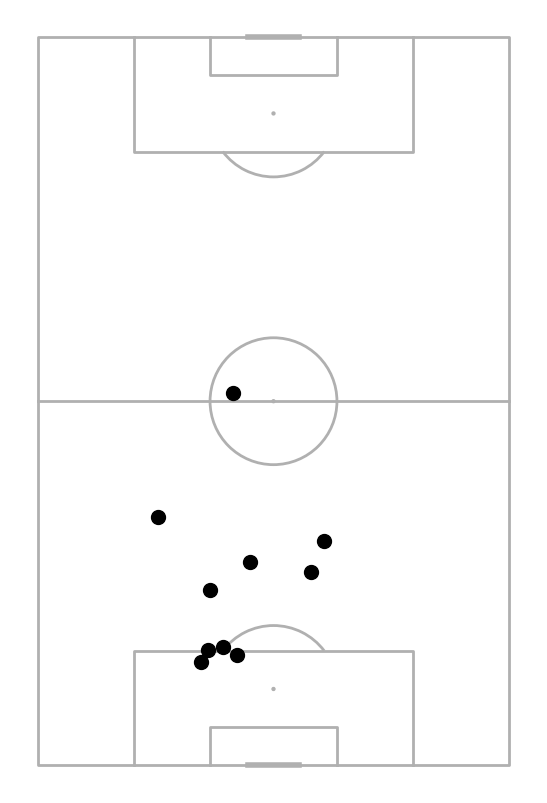

In [3]:
n_players = 10
pplot = PitchPlot(match_id, scale = .1)


field_length_cm = pplot.pitch_length * 100
field_width_cm = pplot.pitch_width * 100

centroid = np.array([field_length_cm, field_width_cm])

f = field_length_cm/2
l = field_width_cm/2
b, r = -f, -l

while centroid[0] <= b or centroid[0] >= f or centroid[1] <= r or centroid[1] >= l:
    centroid = np.array([
        np.random.normal(0,field_length_cm/6),
        np.random.normal(0,field_width_cm/6),
    ])

sigma_x = min(abs(centroid[0] - field_length_cm), abs(centroid[0] + field_length_cm))/6
sigma_y = min(abs(centroid[1] - field_width_cm), abs(centroid[1] + field_width_cm))/6

pts = np.array([
    np.random.normal(centroid[0],sigma_x, n_players),
    np.random.normal(centroid[1],sigma_y, n_players),
])
pts = pts.T


while np.any((pts >= np.array([f, l])).flatten()) or np.any((pts <= np.array([b, r])).flatten()):
    pts = np.array([
        np.random.normal(centroid[0],sigma_x, n_players),
        np.random.normal(centroid[1],sigma_y, n_players),
    ])

    pts = pts.T

players_history.append(pts)

pplot.plot_points(pts)
pplot.show()

## By hand

In [4]:
%matplotlib qt

n_players = 10

drawing_pitch = PitchPlot(match_id)

pts = []
drawing_pitch.draw_points(n_pts = n_players, pts=pts)


Gtk-Message: 16:52:18.004: Failed to load module "appmenu-gtk-module"


(array([], dtype=float64), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

Plot the chosen points:

In [23]:
%matplotlib qt
pts = np.array(pts)

players_history.append(pts)

pplot = PitchPlot(match_id, scale=.1)
pplot.plot_points(pts)
pplot.show()

Gtk-Message: 17:18:40.301: Failed to load module "appmenu-gtk-module"


## From positional data

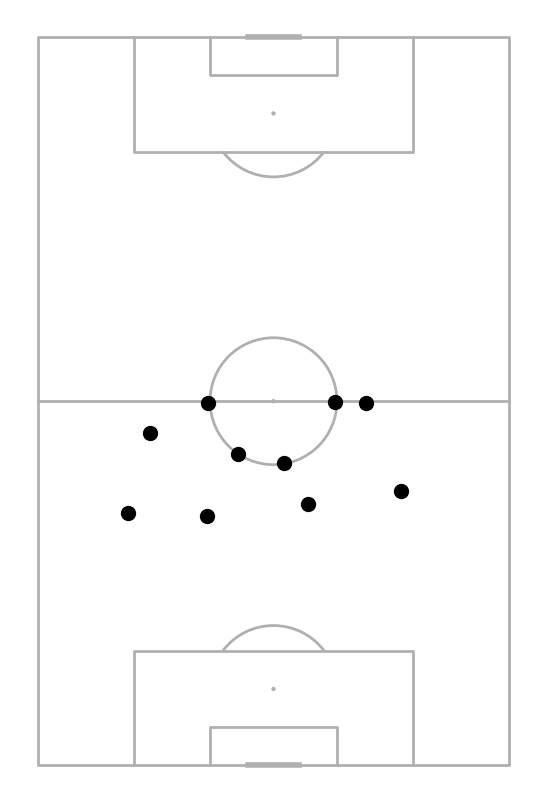

In [3]:
pplot = PitchPlot(match_id, scale = .1)
frame = 0
pts, nos = pplot.get_match_points(1, alive_frame = frame)
n_players = len(pts)
players_history.append(pts)

pplot.plot_points(pts)\
     .show()

# Step one: compute the Delaunay triangulation

We first perform the Delaunay triangulation between the set of player points.

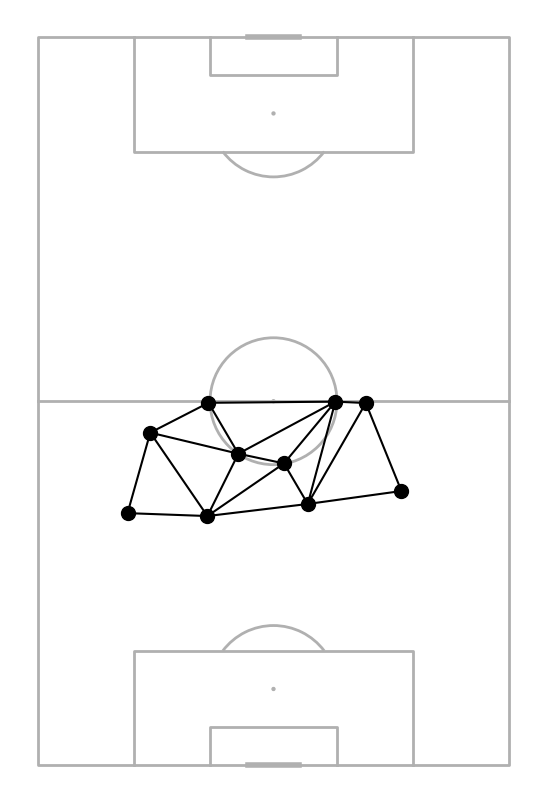

In [4]:
%matplotlib inline

# n_players = 10
# pts = np.array(players_history[-1])[:n_players]

stability = np.zeros((n_players, n_players), dtype=np.float64)
dnay = Delaunay(pts)
simp = dnay.simplices

pplot = PitchPlot(match_id, scale=.1)
pplot.triplot(pts, simp, color="black")\
     .plot_points(pts)\
     .show()


We define `opposite` that is a matrix that contains the vertices that are opposite to the edge.
    
For each counter-clockwise directed edge (P,Q) on the convex hull, the entry (P,Q) contains the index of the vertex in the same triangle, while the entry (Q,P) is -1. For edges inside a quadrangle we can get the two other vertices on the quadrangle by taking the value of (P,Q) and (Q,P). 

To summarize, if (P,Q) is counterclockwise oriented, the entry (P,Q) in the matrix contains the vertex which is left to the edge, and all other entries are -1.

Everything relies on the counterclockwise order given by the Delaunay triangulation from scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html

In [5]:
opposite = np.zeros_like(stability, dtype=np.int16) - 1
next_simp = np.roll(simp, -1, axis=1)
opposite[simp, next_simp] = np.roll(simp, -2, axis=1)
edges = opposite != -1

orig_edges = np.copy(edges)
unstable_inner_edges = np.zeros_like(edges)
orig_opposite = np.copy(opposite)
symm_orig_edges = orig_edges | orig_edges.T
def unstable_edges(): return symm_orig_edges & ~(edges | edges.T)

Outer edges, i.e. the ones that lies on the perimeter of the polygon, only have one opposite opposite vertex, which is the one standing on the left of the edge while walking on the perimeter counterclockwise.

In [6]:

outer = edges & (edges ^ edges.T)
outer_i = np.nonzero(outer)

# Stability for edge at the borders


# Step two: remove unstable edges



## Outer edges stability

For the outer edges stability we compute the distance between the opposite vertex and the line defined by the outer edge.
We use the formula presented here: https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line#Line_defined_by_two_points

In [7]:

def outer_stability(p, q):
    a = opposite[p, q]
    u, v, u_ = pts[[p, q, a]]
    uv = v - u
    u_u = u - u_
    m = np.stack([uv, u_u], axis=1)
    det = np.linalg.det(m)
    delta = np.abs(det) / (2*np.linalg.norm(uv, axis=1))
    stability[p, q] = delta
    # Make stability symmetric
    stability[stability.T > 0] = stability.T[stability.T > 0]


p, q = outer_i
outer_stability(p, q)

## Inner edges stability

For the inner stability we intersect the two perpendicular lines passing at the midpoint of the diagonal edges of the quadrangle.

To compute the intersection we use the matrix inversion.

In [8]:


# Stability for edges with two opposite vertices

inner_i = np.nonzero(np.triu(edges) & ~outer)
p, q = inner_i
a, b = opposite[p, q], opposite[q, p]  # Other two vertices on the quadrangle
u_, v_, u, v = pts[[b, a, p, q]]  # Quadrangle points
uv = v - u
s = (u + v)/2  # midpoint of (u,v)
u_v_ = v_ - u_
s_ = (v_ + u_)/2  # midpoint of (u_,v_)

inv_mat = np.linalg.inv(np.stack([np.stack(
    [-uv[:, 1], -u_v_[:, 1]], axis=1), np.stack([uv[:, 0], u_v_[:, 0]], axis=1)], axis=1))[:, 0]

t = s_ - s
lamb = inv_mat[:, 0] * t[:, 0] + inv_mat[:, 1] * \
    t[:, 1]  # Find the lambda for the intersection
lamb = np.stack([lamb, lamb], axis=1)
# put the found lambda in the line equation
c = lamb * np.stack([-uv[:, 1], uv[:, 0]], axis=1) + s
d_vec_norm = np.linalg.norm(u - c, axis=1)
D_vec_norm = np.linalg.norm(u_ - c, axis=1)
# The stability value is half of the radii difference
delta = (D_vec_norm - d_vec_norm)/2
stability[p, q] = delta
angles = np.zeros((n_players, n_players))

# cycle = np.append(simp, simp[:,0].reshape(simp.shape[0],1), axis=1) # Turn triangles into cycles, by putting the first vertex at the end
# segments = np.linalg.norm(np.diff(pts[cycle],axis=1),axis=2) # Compute the length of each edge of the triangle
# segments_squared = segments ** 2 # Lengths squared
# simp_angles = np.arccos((np.roll(segments_squared,1, axis=1) + np.roll(segments_squared,2, axis=1) - segments_squared) / (2 * np.roll(segments,1, axis=1)*np.roll(segments,2, axis=1))) # Compute the angle of the opposite corner
# angles[simp, next_simp] = simp_angles # Assign vertex tuple to angle
# stability = np.pi - (angles + angles.T)

# Make stability symmetric
stability[stability.T > 0] = stability.T[stability.T > 0]

Here's a plot of the calculated stability, with edges' tickness proportional to the values:

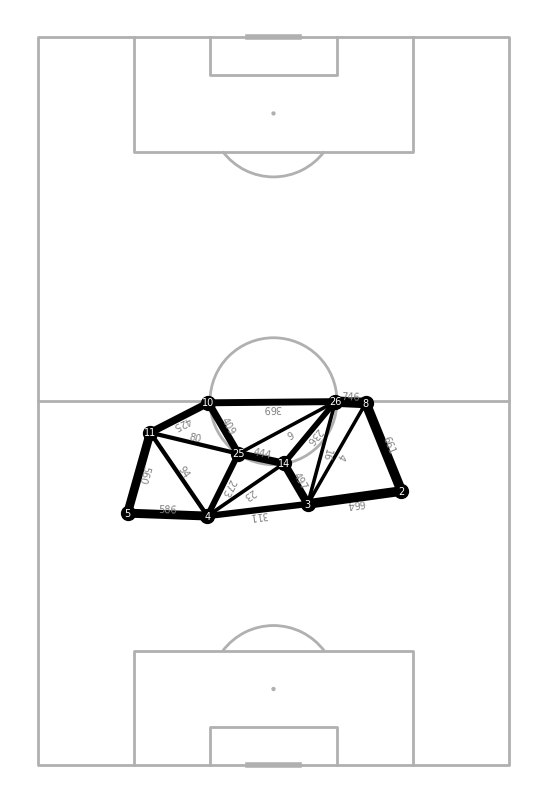

In [9]:
pplot = PitchPlot(match_id, scale=.1)

pplot.plot_edges(pts, orig_edges, stability, unstable_edges(), write_stability=True)\
     .plot_points(pts, numbers=nos)\
     .show()

## Removal of unstable outer edges

We first remove all the unstable outer edges from the least to the most stable, always checking that the other vertex in the same triangle doesn't lie on the perimeter.

An outer edge is unstable if its stability is smaller than all of the other edges in the same triangle.

In [10]:

removed = True
while removed:
    outer = edges & (edges ^ edges.T)
    outer_i = np.nonzero(outer)

    p, q = outer_i

    sort_pq = np.argsort(stability[p, q])
    p, q = p[sort_pq], q[sort_pq]

    # Remove if stability smaller than all the edges on the triangle:
    a = opposite[p, q]
    unstable = stability[p, q] < np.min(stability[[a, q], [p, a]], axis=0)

    if not np.any(unstable):
        break

    p_q = np.append(p, q)
    removed = False
    # Make sure that the other vertex does not lie on the perimeter.
    a_not_on_perimeter = ~np.isin(a[unstable], p_q)

    if np.any(a_not_on_perimeter):
        i = np.argmax(a_not_on_perimeter)
        p_, q_, a_ = p[unstable][i], q[unstable][i], a[unstable][i]
        edges[p_, q_] = False  # Remove outer edge
        # The other two edges are now new outer edges, so their edge exists "only in one direction"
        edges[a_, p_] = False
        edges[q_, a_] = False

        # Update the stability of the two edges
        outer_stability([p_, a_], [a_, q_])
        removed = True

The unstable edges are now dotted:

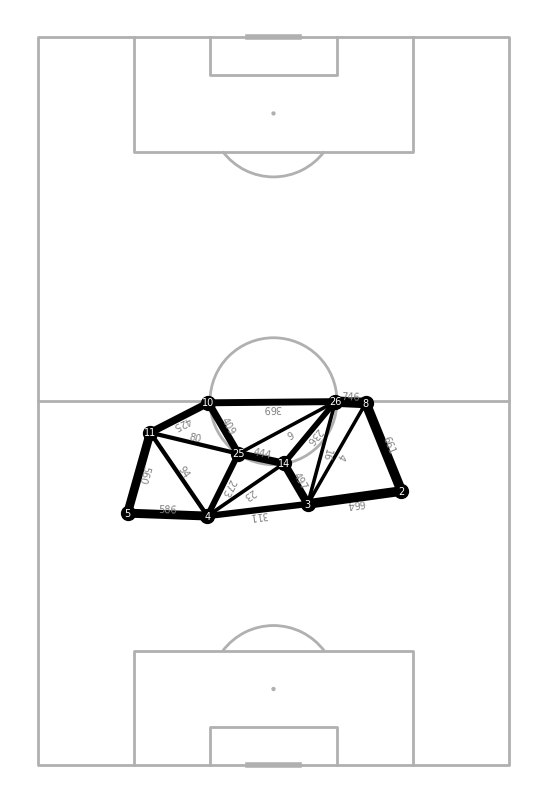

In [11]:
pplot = PitchPlot(match_id, scale=.1)
pplot.plot_edges(pts, orig_edges, stability, unstable_edges(), write_stability=True)\
     .plot_points(pts, numbers=nos)\
     .show()

## Removal of unstable inner edges

We remove all the edges that lie inside a quadrangle and have the stability value smaller than all of the other edges on the quadrangle.

In [12]:
inner = edges & ~outer
assert np.all(inner.T == inner)

inner_i = np.nonzero(inner)
p, q = inner_i
a, b = opposite[p, q], opposite[q, p]
min_quad_stability = np.min(stability[[p, b, a, q], [a, p, q, b]], axis=0)
inner_stable = stability[p, q] >= min_quad_stability
edges[p, q] = inner_stable
inner_unstable = ~inner_stable
p_unst, q_unst = p[inner_unstable], q[inner_unstable]
unstable_inner_edges[p_unst, q_unst] = True

The unstable inner edges are now dotted:

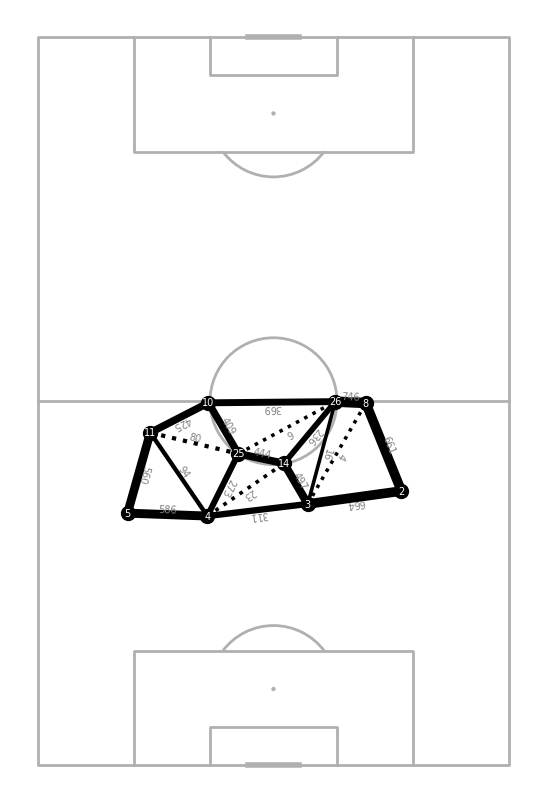

In [13]:
pplot = PitchPlot(match_id, scale=.1)
pplot.plot_edges(pts, orig_edges, stability, unstable_edges(), write_stability=True)\
     .plot_points(pts, numbers=nos)\
     .show()

# Step three: color the edges

## Compute the barycenters

We first compute the barycenter for each outer edge.
If an outer edge is in a triangle we define the barycenter the mean coordinate of the three vertices.

Initially, all the barycenters of the outer edges are computed in this way.

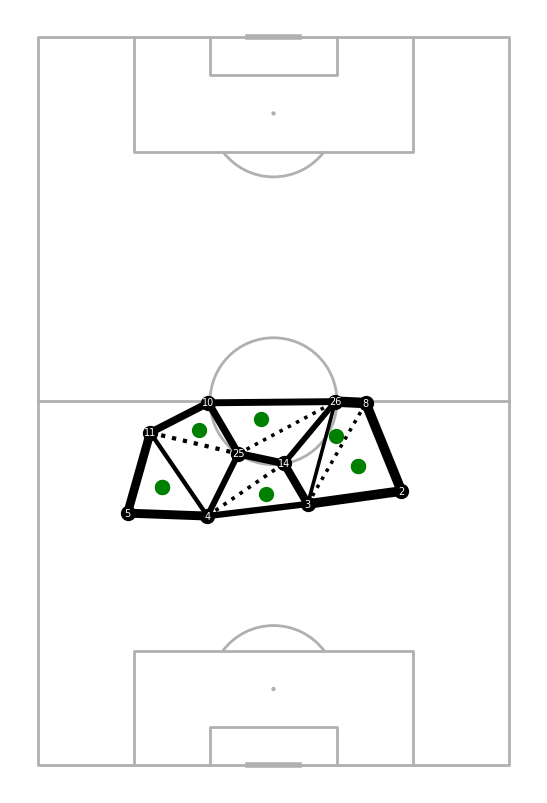

In [14]:
centers = np.zeros((n_players, n_players, 2), np.float64)
tri = simp.T
centers[tri, np.roll(tri, -1, axis=0)] = np.mean(pts[tri], axis=0)

pplot = PitchPlot(match_id, scale=.1)
pplot.plot_edges(pts, orig_edges, stability, unstable_edges())\
     .plot_points(pts, numbers=nos)\
     .plot_points(centers[outer], "green")\
     .show()

If the outer edge is part of a quadrangle, we take the mean of the four vertices' coordinates. We therefore overwrite the barycenter position for all outer edges that lie on a quadrangle.

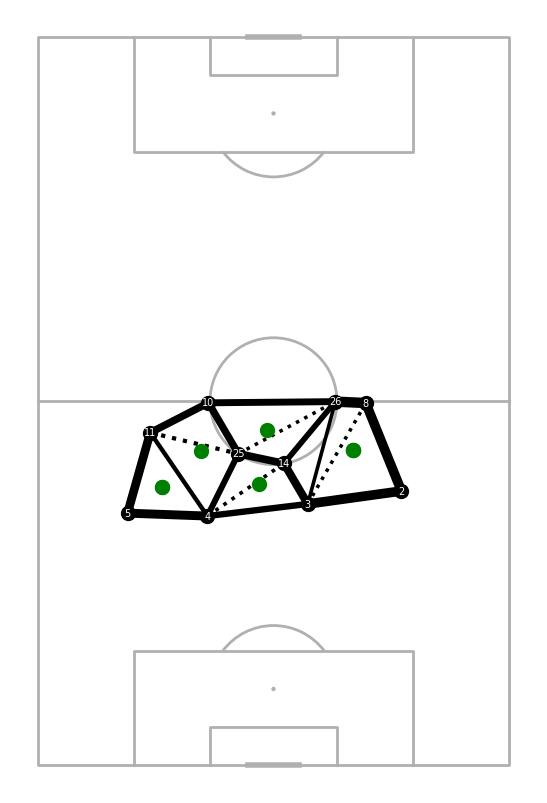

In [15]:

r, s = np.nonzero(unstable_inner_edges)
p, q = opposite[[r, s], [s, r]]
quadrangle = [p, s, q, r]
a, b = quadrangle, np.roll(quadrangle, -1, axis=0)
o = np.mean(pts[quadrangle, :].astype(np.float64), axis=0)
centers[a, b] = o
centers[b, a] = o


pplot = PitchPlot(match_id, scale=.1)
pplot.plot_edges(pts, orig_edges, stability, unstable_edges())\
     .plot_points(pts, numbers=nos)\
     .plot_points(centers[outer], "green")\
     .show()

## Assign colors to edges

We now assign the blue and red color to edges (the other ones remain black).

The first rule is that the edge is blue, resp. red, if $P$ and $Q$ are both below, resp. above, the barycenter of $|PQ|$.

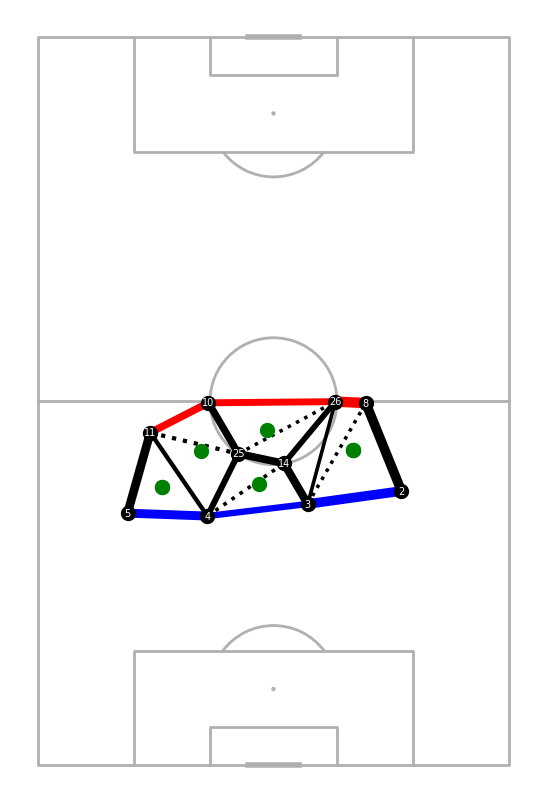

In [16]:
p, q = outer_i
o = centers[p, q]

op = pts[p] - o
oq = pts[q] - o
prod = op * oq
same_side = prod[:, 0] > 0
# same_side means that are both either below or above the barycenter
front = same_side & (op[:, 0] > 0)
back = same_side & (op[:, 0] < 0)

# The following is for visualization only

def matrix(p, q, arr): 
     mat = np.zeros_like(edges)
     mat[p,q] = arr
     return mat

front_ = matrix(p, q, front)
back_ = matrix(p, q, back)


pplot = PitchPlot(match_id, scale=.1)
pplot.plot_edges(pts, orig_edges, stability, unstable_edges(), front=front_, back=back_, write_stability=False)\
     .plot_points(pts, numbers=nos)\
     .plot_points(centers[outer], "green")\
     .show()

The second rule is that if $(P,Q)$ is an outer edge oriented so that $P$ comes before $Q$ while walking on the perimeter in counterclockwise order.
Considering the barycenter $O$ as the origin, $P$ is in the two left, resp. right, quadrants and $Q$ is in the right, resp. left, two, i. e. $P_x < B_x$ and $B_x < Q_x$, resp.

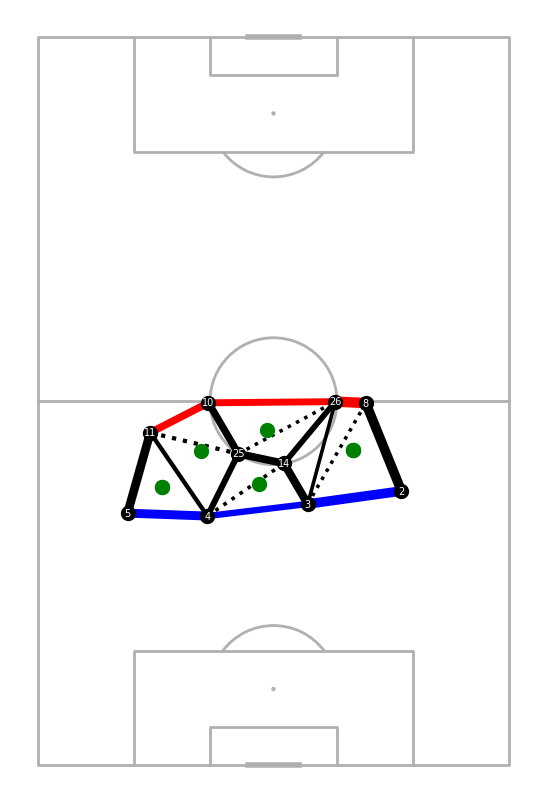

In [17]:

front |= (op[:, 1] < 0) & (oq[:, 1] > 0)
back |= (op[:, 1] > 0) & (oq[:, 1] < 0)

# assert np.all(np.abs(centers[:,:,0] - centers[:,:,0].T)<1e-6)

front_ = matrix(p, q, front)
back_ = matrix(p, q, back)


pplot = PitchPlot(match_id, scale=.1)
pplot.plot_edges(pts, orig_edges, stability, unstable_edges(), front=front_, back=back_, write_stability=False)\
     .plot_points(pts, numbers=nos)\
     .plot_points(centers[outer], "green")\
     .show()


## Make the two colored lines continuous

We first organize the vertices so that they follow the perimeter of in counterclockwise order.

In [18]:
# The following array have for each entry, corresponding to the vertex number, the next vertex in counterclockwise order on the perimeter
outer_adj_list_cckwise = np.zeros(n_players, np.int8) - 1
outer_adj_list_cckwise[p] = q

i_start = np.argmin(pts[p, 0]) # start with the bottommost player
p_start = p[i_start]
q_ = outer_adj_list_cckwise[p_start]
cckwise = np.zeros_like(p)
cckwise[0] = i_start
i = 1
while q_ != p_start:
    cckwise[i] = np.argmax(p == q_) # find the position of vertex in the `p` array
    q_ = outer_adj_list_cckwise[q_]
    i += 1


`cckwise` is now an array which have the position in counterclockwise order for each vertex lying on the perimeter, starting from the bottommost player:

In [19]:
print(nos[cckwise])

[ 4  3  2  8 14 10 11  5]



We use it to order the other arrays:

In [20]:

p = (p[cckwise])
q = (q[cckwise])
front = (front[cckwise])
back = (back[cckwise])

We then make the two lines continuous by taking the first and last edge with the same color and assign it to all the other that are within the two.

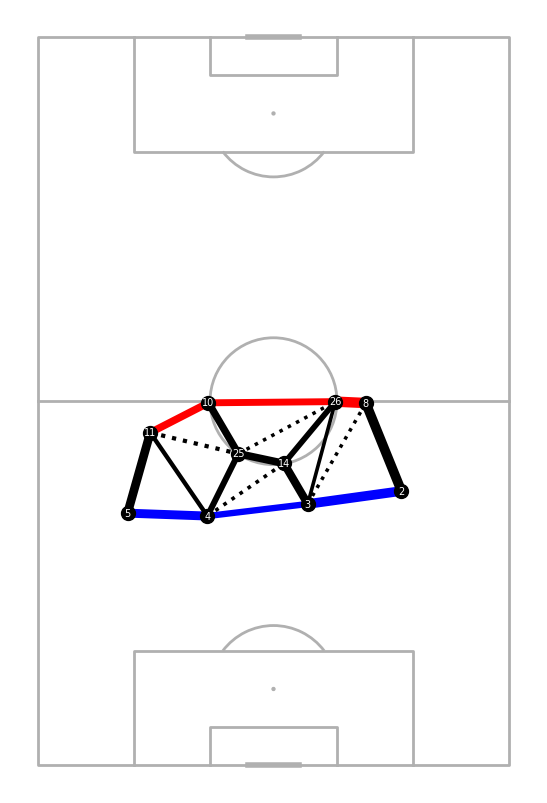

In [21]:
top_player = np.argmax(pts[p,0])
l = len(front)

if not np.any(back):
    # If there is no back edge, only the bottommost player will get the back role
    first_back = last_back = l-top_player 
else:
    # If there is at least one back edge,
    # we roll the array so that it starts from the topmost player.
    # In this way, we make sure that the back line is not broken
    # by the end of the array, i.e. the leftmost back edge comes before the rightmost one.
    back_from_top = np.roll(back, -top_player)
    # We retrieve the first and last edge appearing in the rolled array.
    first_back = np.argmax(back_from_top)
    last_back = l - np.argmax(back_from_top[::-1])
    # We set all the edges between first and last with the same (blue) color
    back_from_top[first_back:last_back] = True
    # We roll the array back
    back = np.roll(back_from_top, top_player)

if not np.any(front):
    # If there is no back edge, only the topmost player will get the back role
    first_front = last_front = top_player
else:
    # Same procedure as with the back line, but since the 
    # but since the front array already starts with the bottommost
    # player, that operation is not needed here. 
    # Hence we only make the front array continuous as done above.
    first_front = np.argmax(front)
    last_front = l - np.argmax(front[::-1])
    front[first_front:last_front] = True

pplot = PitchPlot(match_id, scale=.1)
pplot.plot_edges(pts, orig_edges, stability, unstable_edges(), front=front_, back=back_, write_stability=False)\
     .plot_points(pts, numbers=nos)\
     .show()

Edges that are both blue and green must be black:

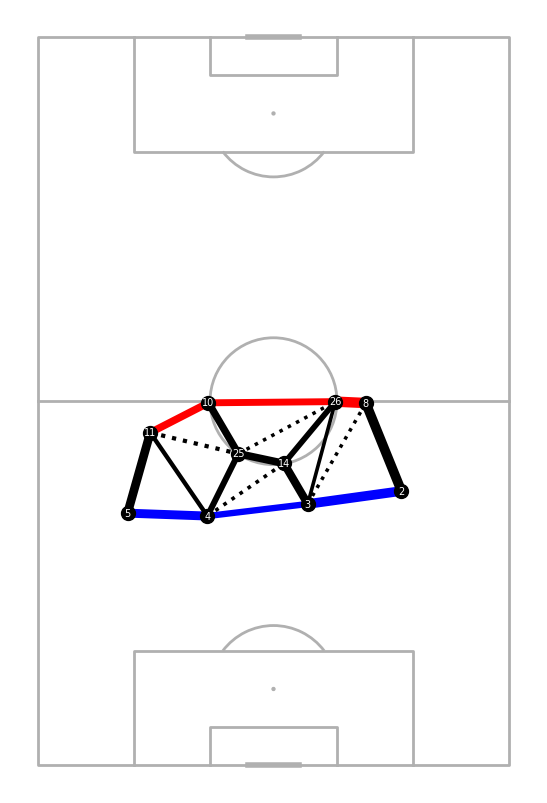

In [22]:
both = front & back
front[both] = False
back[both] = False

pplot = PitchPlot(match_id, scale=.1)
pplot.plot_edges(pts, orig_edges, stability, unstable_edges(), front=front_, back=back_, write_stability=False)\
     .plot_points(pts, numbers=nos)\
     .show()


# Step four: assign the roles

By default, all players gets the central midfielder role.

In [23]:
roles = np.zeros(n_players, np.int8) + 2 # Role 2 is CM

If there is at least one blue edge, assign the back role to all the players adjacent to blue edges.

In [24]:

if np.any(back):
    # Analogous to what is explained above
    back_from_top = np.roll(back, -top_player)
    first_back = np.argmax(back_from_top)
    last_back = (l - np.argmax(back_from_top[::-1]))
    p_from_top = np.roll(p, -top_player)
    roles[p_from_top[first_back:last_back+1]] = 0 # Role 0 is back


Likewise, if there is at least one red edge, assign the forward (front) role to all the players adjacent to blue edges.

In [25]:

if np.any(front):
    first_front = (np.argmax(front))
    last_front = (l - np.argmax(front[::-1]))
    roles[p[first_front:last_front+1]] = 4 # Role 4 is forward

We assign the LM and RM roles to the player that are on the perimeter and stands between the last front, resp back, and the first back, resp front, player (counterclockwise).
If there are two such player we take the most external one (for each of the two role).

In [26]:

# Convert the first_back and last_back indexes to reference the 
# array starting with the bottommost player:
first_back = (first_back + top_player) % l 
last_back = (last_back + top_player) % l

if first_back == 0:
    first_back = l

if last_front == first_back:
    # There can be only one player which is neighbor to both front and back edges.
    lf = last_front % l
    roles[p[lf]] = 1
elif first_back - last_front > 1:
    lefts = p[last_front+1:first_back]
    lmost = np.argmax(pts[lefts, 1]) # the one which is leftmost
    roles[lefts[lmost]] = 1

# Same as above, with right player instead
if first_front == last_back:
    roles[p[last_back]] = 3
elif first_front - last_back > 1:
    rights = p[last_back+1:first_front]
    rmost = np.argmin(pts[rights, 1]) # the one which is rightmost
    roles[rights[rmost]] = 3


Lastly, make sure that the topmost player gets the forward role and the bottommost the back role.

In [27]:

roles[p[0]] = 0
roles[p[top_player]] = 4


The resulting formation is the following one:

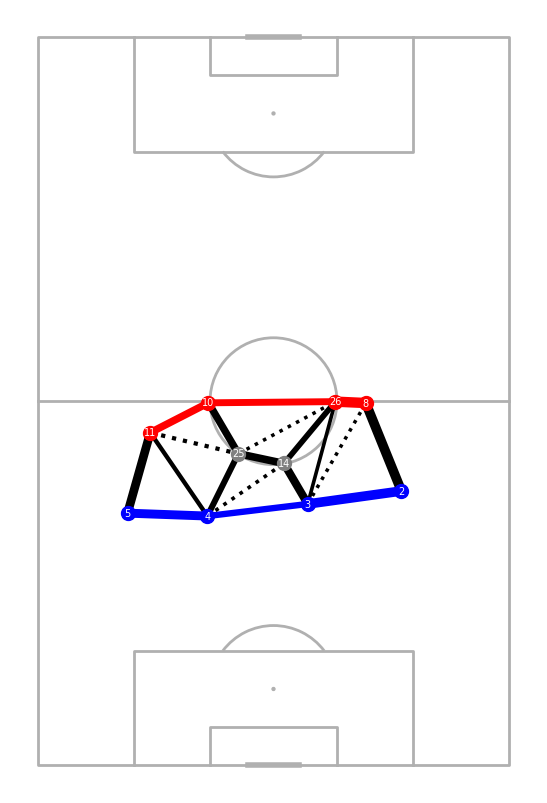

In [28]:
pplot = PitchPlot(match_id, scale=.1)
pplot.plot_edges(pts, orig_edges, stability, unstable_edges(), front=front_, back=back_, write_stability=False)\
     .plot_points_with_role(pts, roles, numbers=nos)\
     .show()

Compute the code.

In [29]:

n_of_codes = 5

code = np.zeros(5, np.int8)

for c in range(n_of_codes):
    code[c] = np.sum(roles == c)


print("The formation code is:","-".join([str(code[0]), "({})".format('-'.join([str(c) for c in code[1:4]])), str(code[4])]))



The formation code is: 4-(0-2-0)-4
